# Problem Statement

Plagiarism is a serious issue in academia and various industries. Manual plagiarism detection is time-consuming and requires significant effort. There is a lack of efficient and accurate plagiarism detection systems in Indian languages such as Hindi, Telugu, and Tamil.

# Plagiarism

- Plagiarism is the act of using or presenting someone else's work or ideas as one's own without giving proper credit or attribution.
- This can include copying or paraphrasing text, images, music, or other creative works without permission or acknowledgement.
- Plagiarism is considered unethical and is often prohibited by academic institutions, professional organisations, and copyright laws.

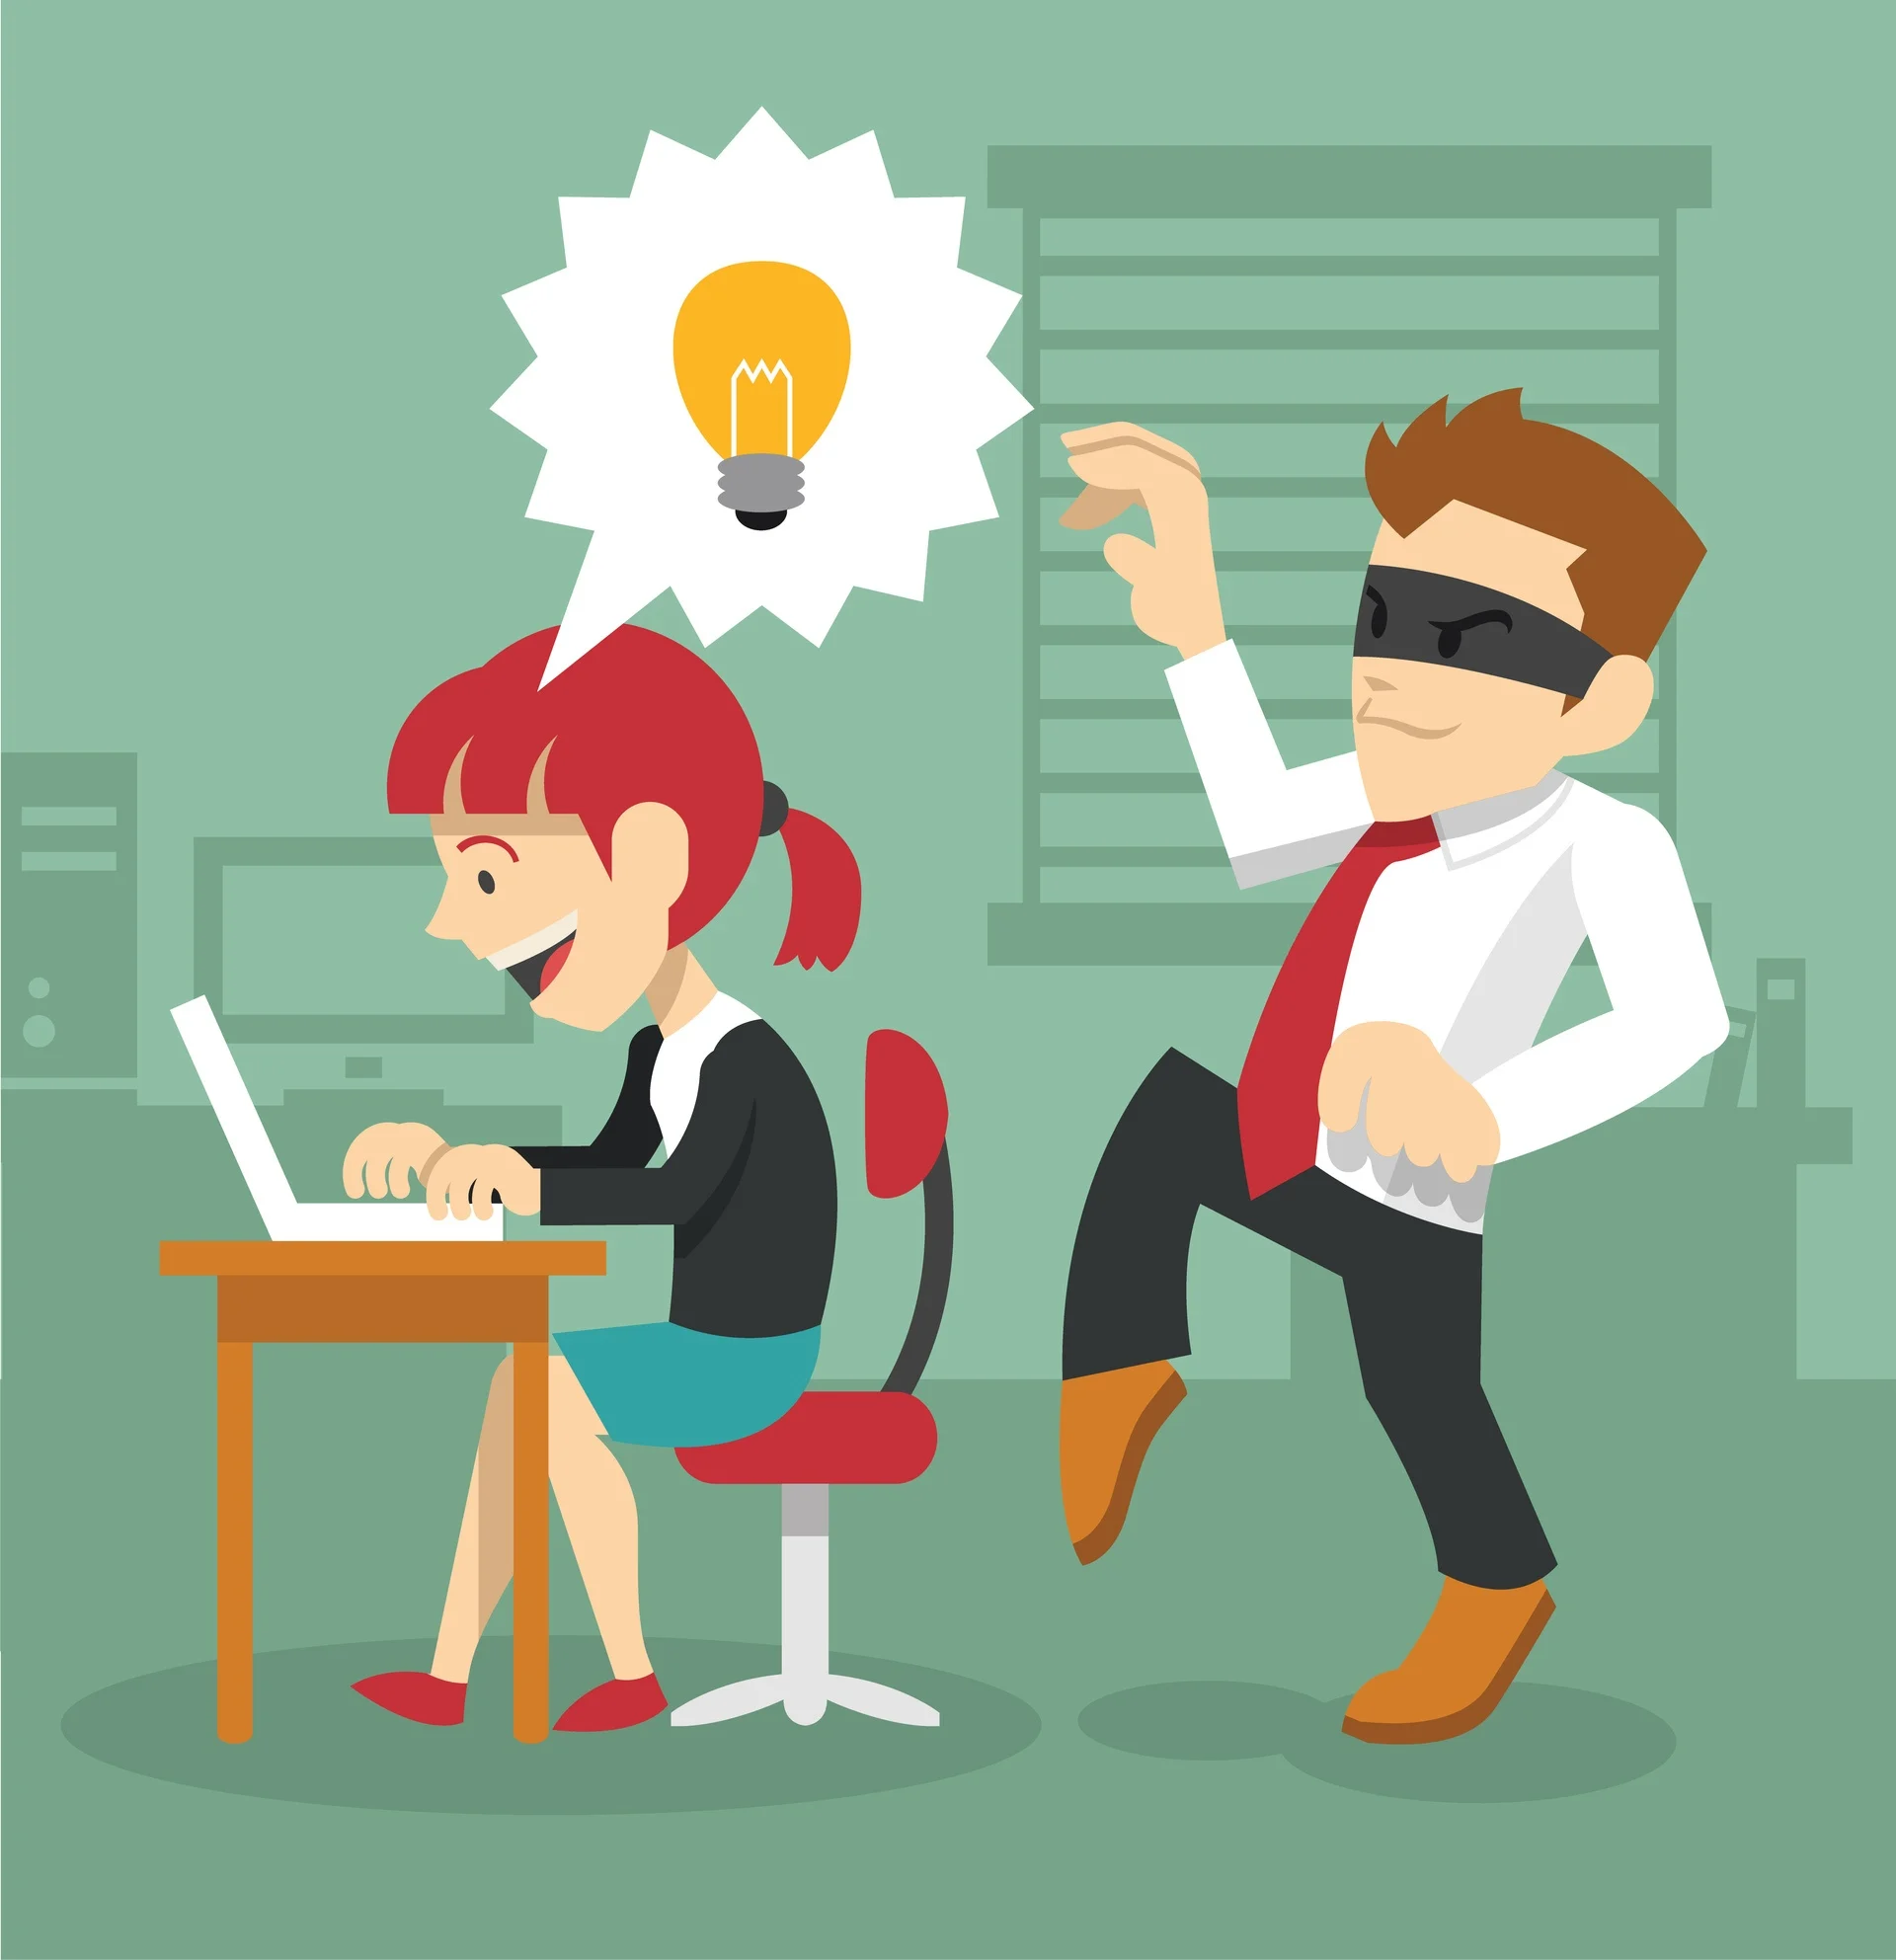

# Contents

* Simple RNN
* Word Embeddings : GLoVe
* LSTM
* GRU
* BI-Directional RNN
* Encoder-Decoder Model (Seq2Seq Model)
* Tamil Model
* Bengali Model
* Telugu Model

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Embedding
from tensorflow.keras.layers import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
!pip install nltk==3.6.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.0 MB/s eta 0:00:0000:010:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.6.2 which is incompatible.


In [4]:
import nltk
print('The nltk version is {}.'.format(nltk.__version__))

The nltk version is 3.6.2.


# Configuring TPU

In [5]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [6]:
train = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv')
validation = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')

We will drop the other columns and approach this problem as a Binary Classification Problem and also we will have our exercise done on a smaller subsection of the dataset(only 12000 data points) to make it easier to train the models

In [7]:
train.drop(['severe_toxic','obscene','threat','insult','identity_hate'],axis=1,inplace=True)

In [8]:
train = train.loc[:12000,:]
train.shape

(12001, 3)

In [9]:
train['comment_text'].apply(lambda x:len(str(x).split())).max()

1403

In [10]:
def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

# Data Preparation

In [11]:
xtrain, xvalid, ytrain, yvalid = train_test_split(train.comment_text.values, train.toxic.values, 
                                                  stratify=train.toxic.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

# Simple RNN

Recurrent Neural Network(RNN) are a type of Neural Network where the output from previous step are fed as input to the current step. In traditional neural networks, all the inputs and outputs are independent of each other, but in cases like when it is required to predict the next word of a sentence, the previous words are required and hence there is a need to remember the previous words. Thus RNN came into existence, which solved this issue with the help of a Hidden Layer.

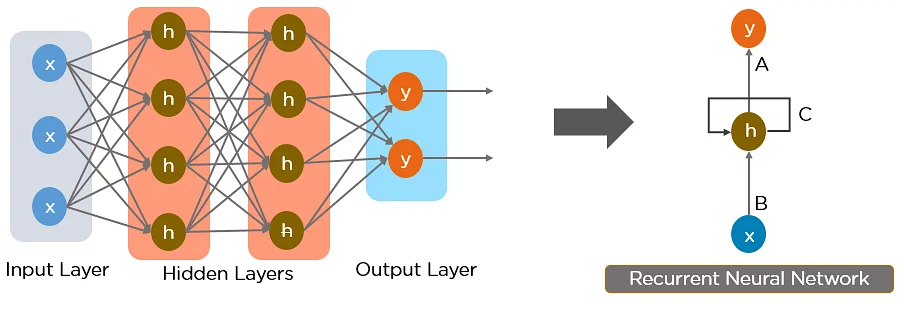

In [22]:
from keras.utils import pad_sequences

# using keras tokenizer here

token = text.Tokenizer(num_words=None)
max_len = 1500

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

#zero pad the sequences
xtrain_pad = pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [23]:
%%time
with strategy.scope():
    # A simpleRNN without any pretrained embeddings and one dense layer
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     input_length=max_len))
    model.add(SimpleRNN(100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1500, 300)         13049100  
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               40100     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 13,089,301
Trainable params: 13,089,301
Non-trainable params: 0
_________________________________________________________________
CPU times: user 325 ms, sys: 40.4 ms, total: 366 ms
Wall time: 1.39 s


In [26]:
model.fit(xtrain_pad, ytrain, epochs=5, batch_size=64*strategy.num_replicas_in_sync) #Multiplying by Strategy to run on TPU's

Epoch 1/5
19/19 [==============================] - 12s 300ms/step - loss: 0.4025 - accuracy: 0.8648
Epoch 2/5
19/19 [==============================] - 1s 70ms/step - loss: 0.2864 - accuracy: 0.9053
Epoch 3/5
19/19 [==============================] - 1s 70ms/step - loss: 0.1958 - accuracy: 0.9291
Epoch 4/5
19/19 [==============================] - 1s 71ms/step - loss: 0.0796 - accuracy: 0.9772
Epoch 5/5
19/19 [==============================] - 1s 72ms/step - loss: 0.0235 - accuracy: 0.9962


In [27]:
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores,yvalid)))

76/76 [==============================] - 2s 16ms/step
Auc: 0.81%


In [28]:
scores_model = []
scores_model.append({'Model': 'SimpleRNN','AUC_Score': roc_auc(scores,yvalid)})

In [29]:
xtrain_seq[:1]

[[664,
  65,
  7,
  19,
  2262,
  14102,
  5,
  2262,
  20439,
  6071,
  4,
  71,
  32,
  20440,
  6620,
  39,
  6,
  664,
  65,
  11,
  8,
  20441,
  1502,
  38,
  6072]]

# What is Padding?

Padding is a technique used in natural language processing and deep learning to handle variable-length input sequences. It involves adding zeros (or other fixed value) to the end of shorter sequences so that all sequences have the same length.

# Word Embeddings

Word embeddings are dense vector representations of words in a high-dimensional space, where each dimension corresponds to a feature. These feature dimensions are learned through training on a large corpus of text data using machine learning algorithms, such as neural networks.

The goal of word embeddings is to capture the meaning and context of words in a more efficient way than traditional methods such as one-hot encoding or bag-of-words representations. By representing words in a dense vector space, word embeddings can capture semantic relationships between words, such as similarity and analogy.

There are several pre-trained word embedding models available such as Word2Vec, GloVe, and fastText, which are trained on large corpora of text data. These pre-trained models can be used directly in a variety of NLP tasks, such as text classification, named entity recognition, and machine translation.

Additionally, we can also train our own custom word embeddings on specific domain-specific datasets, which may result in better performance for the specific task at hand.

In [30]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('/kaggle/input/glove840b300dtxt/glove.840B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196018it [04:40, 7824.93it/s]

Found 2196017 word vectors.


# LSTM

LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) architecture that is commonly used in natural language processing (NLP) tasks.

Unlike traditional RNNs, LSTM networks have the ability to selectively forget or remember information over time, making them particularly useful for modeling sequences of data, such as text. LSTM networks consist of cells that contain hidden states, which are used to store and update information over time.

Each cell has three gates: the input gate, output gate, and forget gate. The input gate controls the flow of information into the cell, the output gate controls the flow of information out of the cell, and the forget gate controls which information is retained or discarded from the cell's memory.

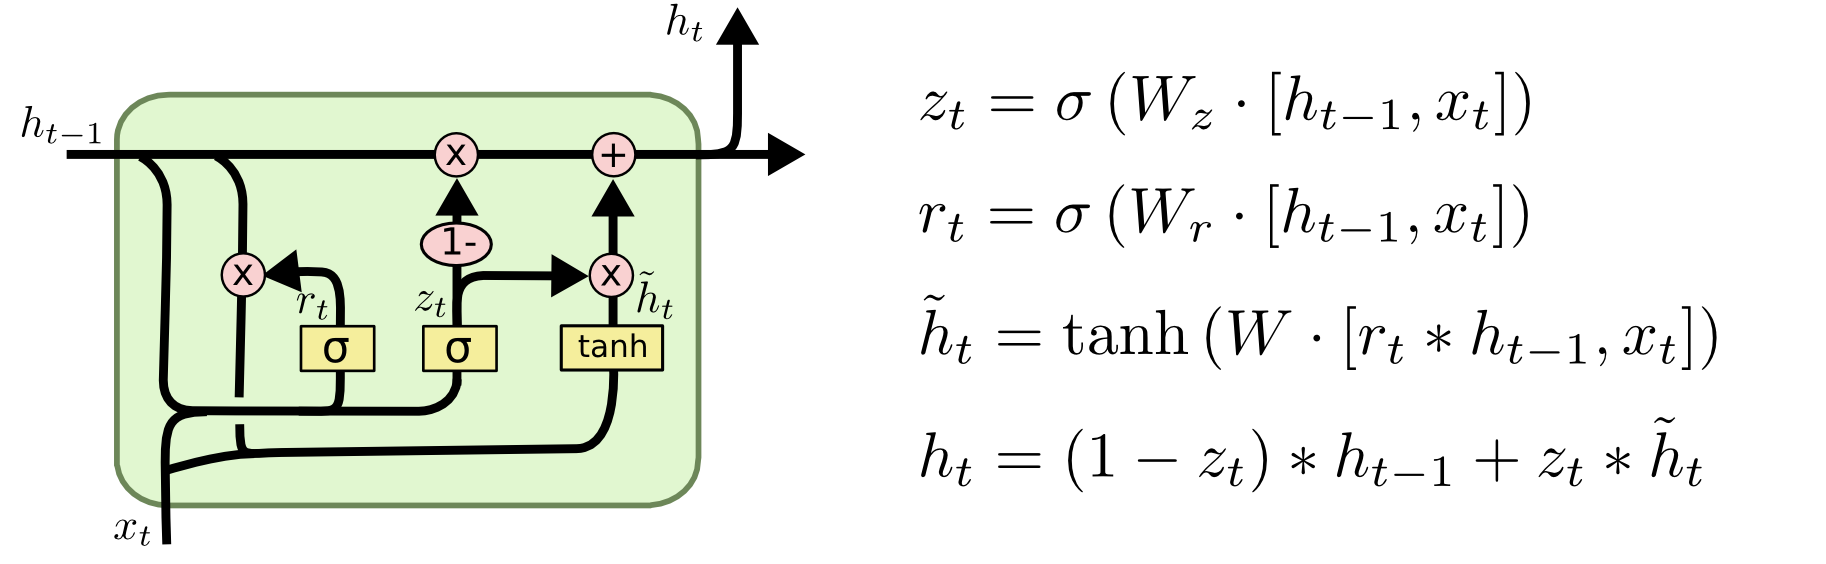

In [31]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 43496/43496 [00:00<00:00, 79219.39it/s]


In [32]:
%%time
with strategy.scope():
    
    # A simple LSTM with glove embeddings and one dense layer
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))

    model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1500, 300)         13049100  
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 13,209,601
Trainable params: 160,501
Non-trainable params: 13,049,100
_________________________________________________________________
CPU times: user 983 ms, sys: 1.37 s, total: 2.36 s
Wall time: 2.82 s


In [33]:
model.fit(xtrain_pad, ytrain, epochs=5, batch_size=64*strategy.num_replicas_in_sync)

Epoch 1/5
19/19 [==============================] - 14s 314ms/step - loss: 0.3346 - accuracy: 0.8988
Epoch 2/5
19/19 [==============================] - 3s 170ms/step - loss: 0.2313 - accuracy: 0.9221
Epoch 3/5
19/19 [==============================] - 3s 172ms/step - loss: 0.1775 - accuracy: 0.9353
Epoch 4/5
19/19 [==============================] - 3s 172ms/step - loss: 0.1518 - accuracy: 0.9450
Epoch 5/5
19/19 [==============================] - 3s 170ms/step - loss: 0.1381 - accuracy: 0.9505


In [34]:
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores,yvalid)))

76/76 [==============================] - 5s 55ms/step
Auc: 0.97%


In [35]:
scores_model.append({'Model': 'LSTM','AUC_Score': roc_auc(scores,yvalid)})

# GRU

GRU stands for Gated Recurrent Unit, which is another type of recurrent neural network (RNN) like LSTM. GRU was proposed by Cho et al. in 2014 as a simpler alternative to LSTM, which can capture long-term dependencies and avoid the vanishing gradient problem.

The main difference between GRU and LSTM is that GRU has two gates (reset gate and update gate) instead of three (input gate, output gate, and forget gate) in LSTM. The reset gate controls how much of the past information should be forgotten, while the update gate controls how much of the new information should be added. GRU also has a hidden state that is updated based on the previous hidden state and the input at each time step.

GRU has shown to be competitive with LSTM in many natural language processing (NLP) tasks such as language modeling, machine translation, and sentiment analysis. Its simpler structure allows it to be trained faster and with less memory than LSTM.

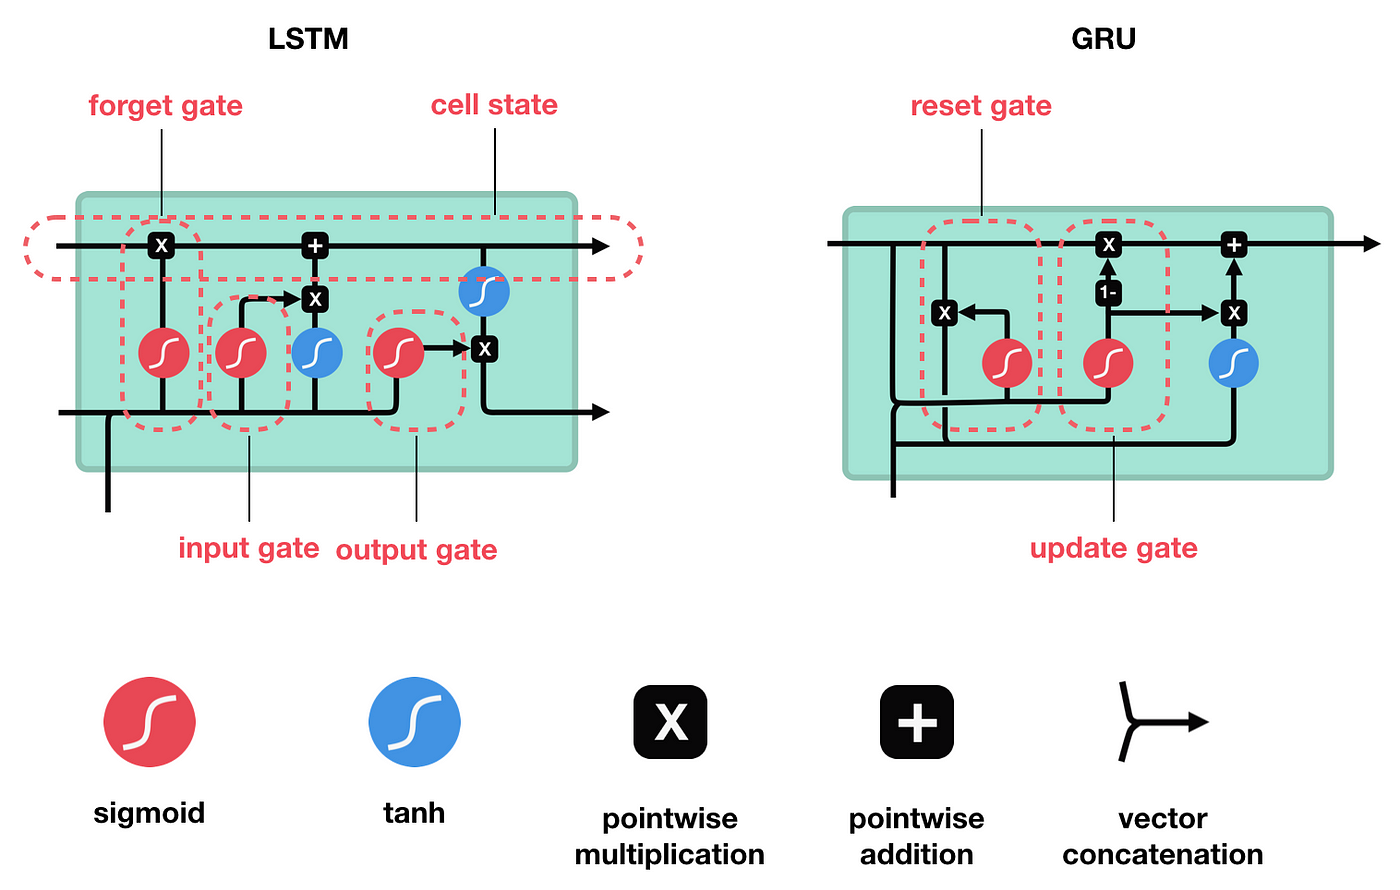

In [36]:
%%time
with strategy.scope():
    # GRU with glove embeddings and two dense layers
     model = Sequential()
     model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
     model.add(SpatialDropout1D(0.3))
     model.add(GRU(300))
     model.add(Dense(1, activation='sigmoid'))

     model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])   
    
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1500, 300)         13049100  
                                                                 
 spatial_dropout1d (SpatialD  (None, 1500, 300)        0         
 ropout1D)                                                       
                                                                 
 gru (GRU)                   (None, 300)               541800    
                                                                 
 dense_2 (Dense)             (None, 1)                 301       
                                                                 
Total params: 13,591,201
Trainable params: 542,101
Non-trainable params: 13,049,100
_________________________________________________________________
CPU times: user 975 ms, sys: 1.11 s, total: 2.08 s
Wall time: 3.36 s


In [37]:
model.fit(xtrain_pad, ytrain, epochs=5, batch_size=64*strategy.num_replicas_in_sync)

Epoch 1/5
19/19 [==============================] - 12s 285ms/step - loss: 0.3196 - accuracy: 0.8954
Epoch 2/5
19/19 [==============================] - 3s 163ms/step - loss: 0.2013 - accuracy: 0.9350
Epoch 3/5
19/19 [==============================] - 3s 160ms/step - loss: 0.1561 - accuracy: 0.9474
Epoch 4/5
19/19 [==============================] - 3s 162ms/step - loss: 0.1333 - accuracy: 0.9502
Epoch 5/5
19/19 [==============================] - 3s 164ms/step - loss: 0.1212 - accuracy: 0.9561


In [38]:
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores,yvalid)))

76/76 [==============================] - 5s 49ms/step
Auc: 0.98%


In [39]:
scores_model.append({'Model': 'GRU','AUC_Score': roc_auc(scores,yvalid)})

In [40]:
scores_model

[{'Model': 'SimpleRNN', 'AUC_Score': 0.8082079359997406},
 {'Model': 'LSTM', 'AUC_Score': 0.9733534887679383},
 {'Model': 'GRU', 'AUC_Score': 0.9802532127789778}]

# Bi-Directional RNN

A Bi-Directional RNN (Recurrent Neural Network) is a type of neural network that processes inputs in two ways - in a forward direction and in a backward direction. The output is then obtained by combining the results of both the forward and backward passes.

In a regular RNN, the output at time t is computed based on the inputs up to time t and the hidden state at time t-1. However, in a Bi-Directional RNN, the output at time t is computed based on the inputs up to time t, as well as the hidden states of the forward and backward RNNs at time t.

This means that a Bi-Directional RNN can take into account not only the past information but also the future information while making predictions. This makes it particularly useful in tasks where the context is important, such as natural language processing (NLP) tasks like sentiment analysis, machine translation, and speech recognition.

In a Bi-Directional LSTM (Long Short-Term Memory) network, both the forward and backward passes use LSTM cells, which are a type of RNN cell that can maintain long-term memory. This allows the network to better capture long-term dependencies in the input data.

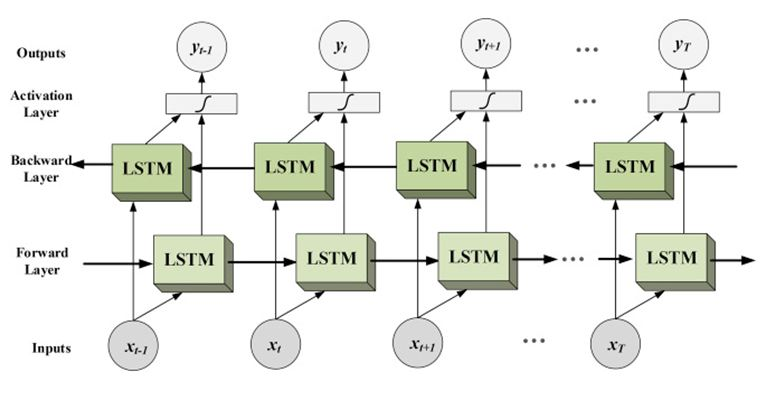

In [41]:
%%time
with strategy.scope():
    # A simple bidirectional LSTM with glove embeddings and one dense layer
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
    model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
    
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1500, 300)         13049100  
                                                                 
 bidirectional (Bidirectiona  (None, 600)              1442400   
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 601       
                                                                 
Total params: 14,492,101
Trainable params: 1,443,001
Non-trainable params: 13,049,100
_________________________________________________________________
CPU times: user 1.02 s, sys: 790 ms, total: 1.81 s
Wall time: 3.22 s


In [42]:
model.fit(xtrain_pad, ytrain, epochs=5, batch_size=64*strategy.num_replicas_in_sync)

Epoch 1/5
19/19 [==============================] - 28s 842ms/step - loss: 0.3186 - accuracy: 0.8968
Epoch 2/5
19/19 [==============================] - 11s 597ms/step - loss: 0.1935 - accuracy: 0.9307
Epoch 3/5
19/19 [==============================] - 11s 597ms/step - loss: 0.1918 - accuracy: 0.9287
Epoch 4/5
19/19 [==============================] - 11s 597ms/step - loss: 0.1589 - accuracy: 0.9425
Epoch 5/5
19/19 [==============================] - 11s 597ms/step - loss: 0.1578 - accuracy: 0.9476


In [43]:
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores,yvalid)))

76/76 [==============================] - 10s 121ms/step
Auc: 0.95%


In [44]:
scores_model.append({'Model': 'Bi-directional LSTM','AUC_Score': roc_auc(scores,yvalid)})

# Seq2Seq Model Architecture

The Seq2Seq (Sequence-to-Sequence) model architecture is a type of neural network that is widely used for tasks such as machine translation, text summarization, and speech recognition. The architecture consists of two main components: an encoder and a decoder.

The encoder takes a sequence of input tokens, such as words in a sentence, and transforms them into a fixed-length vector representation called a context vector. The context vector represents the meaning of the input sequence and is used by the decoder to generate the output sequence.

The decoder is another RNN that takes the context vector and generates an output sequence, one token at a time. At each time step, the decoder outputs a probability distribution over the vocabulary of possible output tokens, and selects the most likely token as the next output.

During training, the model is fed pairs of input and output sequences, and the parameters of the encoder and decoder are optimized to minimize the difference between the predicted output sequence and the target output sequence.

The Seq2Seq architecture has proven to be very effective for a wide range of natural language processing tasks and is widely used in industry and academia.

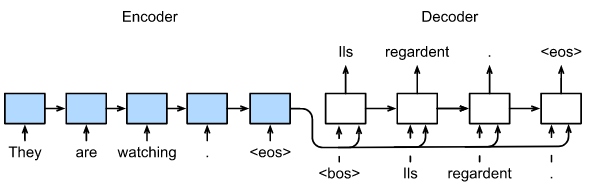

In [45]:
# Visualization of Results obtained from various Deep learning models
results = pd.DataFrame(scores_model).sort_values(by='AUC_Score',ascending=False)
results.style.background_gradient(cmap='Blues')

,Model,AUC_Score
2,GRU,0.980253
1,LSTM,0.973353
3,Bi-directional LSTM,0.953199
0,SimpleRNN,0.808208


In [48]:
fig = go.Figure(go.Funnelarea(
    text =results.Model,
    values = results.AUC_Score,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

# Tamil

In [49]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/glove840b300dtxt/glove.840B.300d.txt
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test_labels.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train-processed-seqlen128.csv


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.layers import SpatialDropout1D
from keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.preprocessing import sequence
from sklearn.feature_selection import RFE
import re
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [51]:
train = pd.read_csv('/kaggle/input/tamildataset/tamil_news_train.csv')
test = pd.read_csv('/kaggle/input/tamildataset/tamil_news_test.csv')

# Text Pre-processing

In [52]:
# fix random seed for reproducibility
np.random.seed(7)
train = train.drop_duplicates().reset_index(drop=True)
test = test.drop_duplicates().reset_index(drop=True)

In [53]:
stop_words = stopwords.words('english')

train.NewsInEnglish = train.NewsInEnglish.str.lower()
train.NewsInEnglish = train.NewsInEnglish.str.replace('[^\w\s]',' ')
train.NewsInEnglish = train.NewsInEnglish.str.replace('\d+', ' ')
train.NewsInEnglish = train.NewsInEnglish.str.replace(' txt', '')
train.NewsInEnglish = train.NewsInEnglish.apply(lambda x: [item for item in [x] if item not in stop_words])
count = 0
for i in range(len(train.NewsInEnglish)):
    train.NewsInEnglish[count] = train.NewsInEnglish[count][0].replace('  ', '')
#     train.NewsInEnglish[count] = train.NewsInEnglish[count][0].split(' ')
    count = count + 1
    
train.NewsInTamil = train.NewsInTamil.str.lower()
train.NewsInTamil = train.NewsInTamil.str.replace('[^\w\s]',' ')
train.NewsInTamil = train.NewsInTamil.str.replace('\d+', ' ')

test.NewsInTamil = test.NewsInTamil.str.lower()
test.NewsInTamil = test.NewsInTamil.str.replace('[^\w\s]',' ')
test.NewsInTamil = test.NewsInTamil.str.replace('\d+', ' ')

test.NewsInEnglish = test.NewsInEnglish.str.lower()
test.NewsInEnglish = test.NewsInEnglish.str.replace('[^\w\s]',' ')
test.NewsInEnglish = test.NewsInEnglish.str.replace('\d+', ' ')
test.NewsInEnglish = test.NewsInEnglish.str.replace(' txt', '')
test.NewsInEnglish = test.NewsInEnglish.apply(lambda x: [item for item in [x] if item not in stop_words])    
count = 0
for i in range(len(test.NewsInEnglish)):
    test.NewsInEnglish[count] = test.NewsInEnglish[count][0].replace('  ', '')
#     test.NewsInEnglish[count] = test.NewsInEnglish[count][0].split(' ')
    count = count + 1
    
train = train.append(test)
df = train
df.head()
df.shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

The default value of regex will change from True to False in a future version.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

The default value of regex will change from True to False in a future version.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning:

The default value of regex will change from True to False in a future version.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning:

The default value of regex will change from True to False in a future version.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning:

The default value of regex will change from True to False in a future version.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning:

The default value of regex will change from True to False in a future version.

/opt/conda/lib/python3.7/site-packag

,NewsInEnglish,NewsInTamil,Category,CategoryInTamil
0,may miss iraq competition after years,ஈர க க ல ஆண ட கள கழ த த அழக ப ப ட ட,world,உலகம்
1,dec viswasam s rustic folk song has been released,இந த ய அளவ ல ட ர ண ட ஆன அஜ த த ன தள ல த ல...,cinema,சினிமா
2,dec inspector who bought insurance at his own ...,ச ந த ச லவ ல வ கன க ப ப ட எட த த க ட த த க ...,tamilnadu,தமிழ்நாடு
3,jan morarji desai budget,ப றந தந ள ல பட ஜ ட த க கல ச ய தவர,india,இந்தியா
4,jun i have not joined bjp or anyother politica...,ந ன ப ஜகவ ல இண ந த வ ட ட ன வரலட ச ம வ...,cinema,சினிமா


(13955, 4)

In [54]:
df.Category.unique()
df.CategoryInTamil.unique()

array(['world', 'cinema', 'tamilnadu', 'india', 'politics', 'sports'],
      dtype=object)

array([' உலகம்', ' சினிமா', ' தமிழ்நாடு', ' இந்தியா', ' அரசியல்',
       ' விளையாட்டு'], dtype=object)

In [55]:
df.Category = df.Category.replace('world', 1)
df.Category = df.Category.replace('cinema', 2)
df.Category = df.Category.replace('tamilnadu', 3)
df.Category = df.Category.replace('india', 4)
df.Category = df.Category.replace('politics', 5)
df.Category = df.Category.replace('sports', 6)

df.CategoryInTamil = df.CategoryInTamil.replace(' உலகம்', 1)
df.CategoryInTamil = df.CategoryInTamil.replace(' சினிமா', 2)
df.CategoryInTamil = df.CategoryInTamil.replace(' தமிழ்நாடு', 3)
df.CategoryInTamil = df.CategoryInTamil.replace(' இந்தியா', 4)
df.CategoryInTamil = df.CategoryInTamil.replace(' அரசியல்', 5)
df.CategoryInTamil = df.CategoryInTamil.replace(' விளையாட்டு', 6)

df.Category.head()
df.CategoryInTamil.head()

0    1
1    2
2    3
3    4
4    2
Name: Category, dtype: int64

0    1
1    2
2    3
3    4
4    2
Name: CategoryInTamil, dtype: int64

In [56]:
# The maximum number of words to be used most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df.NewsInEnglish.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 13465 unique tokens.


In [57]:
X = tokenizer.texts_to_sequences(df.NewsInEnglish.values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (13955, 250)


In [58]:
Y = pd.get_dummies(df.Category).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (13955, 6)


# Training Model

In [59]:
train_features, test_features, train_labels, test_labels = train_test_split(X, Y, test_size=.20)

In [60]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_features, train_labels, epochs=5, batch_size=64,validation_split=0.2)
# Final evaluation of the model
model_pred_train = model.predict(train_features)
model_pred_test = model.predict(test_features)
# print(classification_report(test_labels,model_pred_test))
print('LSTM Recurrent Neural Network baseline: ' + str(roc_auc_score(train_labels, model_pred_train)))
print('LSTM Recurrent Neural Network: ' + str(roc_auc_score(test_labels, model_pred_test)))

Epoch 1/5
140/140 [==============================] - 31s 195ms/step - loss: 1.4733 - accuracy: 0.4352 - val_loss: 1.0660 - val_accuracy: 0.6305
Epoch 2/5
140/140 [==============================] - 27s 190ms/step - loss: 0.7819 - accuracy: 0.7298 - val_loss: 0.7811 - val_accuracy: 0.7376
Epoch 3/5
140/140 [==============================] - 27s 191ms/step - loss: 0.4036 - accuracy: 0.8688 - val_loss: 0.7566 - val_accuracy: 0.7452
Epoch 4/5
140/140 [==============================] - 27s 191ms/step - loss: 0.2359 - accuracy: 0.9251 - val_loss: 0.8331 - val_accuracy: 0.7429
Epoch 5/5
88/88 [==============================] - 2s 26ms/step
LSTM Recurrent Neural Network baseline: 0.9904417243105708
LSTM Recurrent Neural Network: 0.9335208675192734


Text(0.5, 1.0, 'Loss')

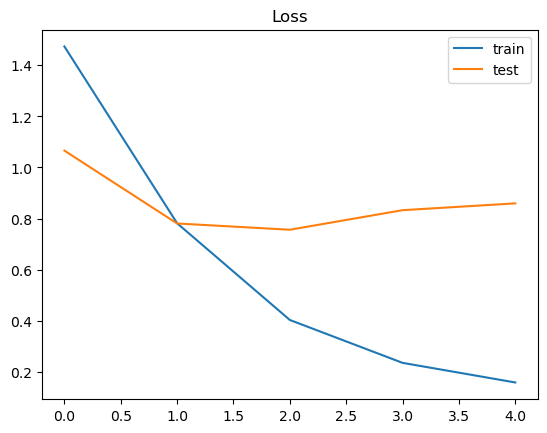

Text(0.5, 1.0, 'Accuracy')

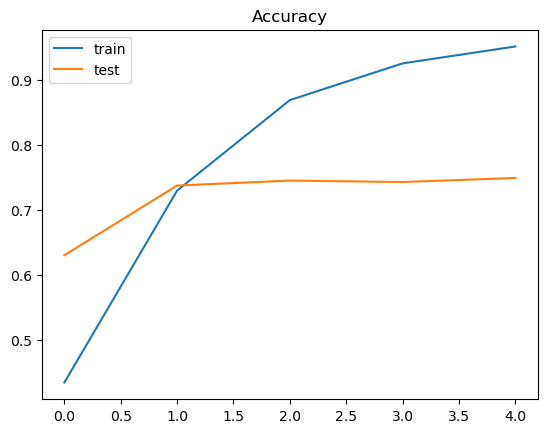

In [61]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [62]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df.NewsInEnglish.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 13465 unique tokens.


In [63]:
X = tokenizer.texts_to_sequences(df.NewsInEnglish.values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (13955, 250)


In [64]:
Y = pd.get_dummies(df.Category).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (13955, 6)


In [65]:
train_features, test_features, train_labels, test_labels = train_test_split(X, Y, test_size=.20)

In [66]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_features, train_labels, epochs=5, batch_size=64,validation_split=0.2)
# Final evaluation of the model
model_pred_train = model.predict(train_features)
model_pred_test = model.predict(test_features)
# print(classification_report(test_labels,model_pred_test))
print('LSTM Recurrent Neural Network baseline: ' + str(roc_auc_score(train_labels, model_pred_train)))
print('LSTM Recurrent Neural Network: ' + str(roc_auc_score(test_labels, model_pred_test)))

Epoch 1/5
140/140 [==============================] - 31s 194ms/step - loss: 1.4761 - accuracy: 0.4288 - val_loss: 1.1141 - val_accuracy: 0.6350
Epoch 2/5
140/140 [==============================] - 27s 189ms/step - loss: 0.7583 - accuracy: 0.7445 - val_loss: 0.7638 - val_accuracy: 0.7277
Epoch 3/5
140/140 [==============================] - 27s 190ms/step - loss: 0.3884 - accuracy: 0.8762 - val_loss: 0.7303 - val_accuracy: 0.7546
Epoch 4/5
140/140 [==============================] - 27s 189ms/step - loss: 0.2183 - accuracy: 0.9324 - val_loss: 0.7880 - val_accuracy: 0.7640
Epoch 5/5
88/88 [==============================] - 2s 25ms/step
LSTM Recurrent Neural Network baseline: 0.9912298739579756
LSTM Recurrent Neural Network: 0.9368470593399366


Text(0.5, 1.0, 'Loss')

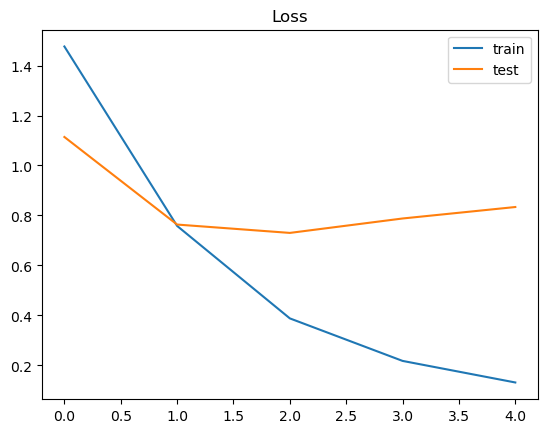

Text(0.5, 1.0, 'Accuracy')

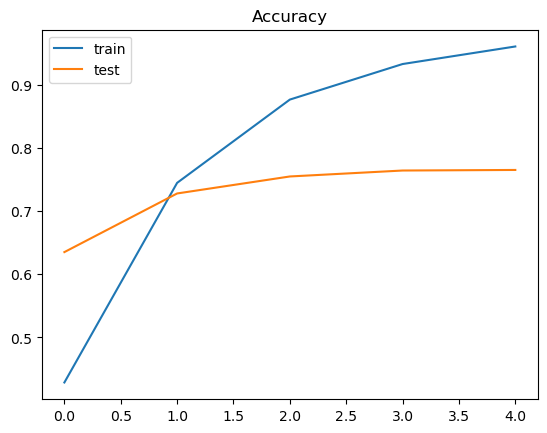

In [67]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

# Bengali

In [68]:
import pandas as pd
import itertools
import os
import numpy as np # linear algebra
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
import keras.utils as ku
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
from keras.layers import Dropout
from keras import optimizers

from numpy.random import seed


layers = keras.layers
models = keras.models

In [69]:
df = pd.read_excel("/kaggle/input/bengali-news-headline-categories/Bengali_News_Headline.xlsx")

In [70]:
df.head()

,NewsType,Headline
0,অর্থনীতি,‘২০ রোজার মধ্যে পাটকল শ্রমিকদের মজুরি দিন’
1,খেলাধুলা,"‘২০০’ ডাকছে, তামিম রাঙাতে পারবেন তো?"
2,মতামত,‘২০টি মডেল ভবন তৈরি করে দেখান’
3,বাংলাদেশ,‘৬ মাসে ২০৮৩ নারী ও শিশু নির্যাতনের শিকার’
4,খেলাধুলা,‘৯০ মাইল বেগে বল করলেই গ্রেট হওয়া যায় না’


In [71]:
for i in range(5):
    print("News:", i+1)
    print("Text:", df.Headline[i])
    print("NewsType:", df.NewsType[i])

News: 1
Text: ‘২০ রোজার মধ্যে পাটকল শ্রমিকদের মজুরি দিন’
NewsType: অর্থনীতি 
News: 2
Text: ‘২০০’ ডাকছে, তামিম রাঙাতে পারবেন তো?
NewsType: খেলাধুলা 
News: 3
Text: ‘২০টি মডেল ভবন তৈরি করে দেখান’
NewsType: মতামত 
News: 4
Text: ‘৬ মাসে ২০৮৩ নারী ও শিশু নির্যাতনের শিকার’
NewsType: বাংলাদেশ 
News: 5
Text: ‘৯০ মাইল বেগে বল করলেই গ্রেট হওয়া যায় না’
NewsType: খেলাধুলা 


In [72]:
contractions = { 
"বি.দ্র ": "বিশেষ দ্রষ্টব্য",
"ড.": "ডক্টর",
"ডা.": "ডাক্তার",
"ইঞ্জি:": "ইঞ্জিনিয়ার",
"রেজি:": "রেজিস্ট্রেশন",
"মি.": "মিস্টার",
"মু.": "মুহাম্মদ",
"মো.": "মোহাম্মদ",
}

# Text Pre-Processing

In [73]:
import string
import re

def clean_text(text,remove_stopwords = False):
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    # Format words and remove unwanted characters
    whitespace = re.compile(u"[\s\u0020\u00a0\u1680\u180e\u202f\u205f\u3000\u2000-\u200a]+", re.UNICODE)
    bangla_digits = u"[\u09E6\u09E7\u09E8\u09E9\u09EA\u09EB\u09EC\u09ED\u09EE\u09EF]+"
    english_chars = u"[a-zA-Z0-9]"
    punc = u"[(),$%^&*+={}\[\]:\"|\'\~`<>/,¦!?½£¶¼©⅐⅑⅒⅓⅔⅕⅖⅗⅘⅙⅚⅛⅜⅝⅞⅟↉¤¿º;-]+"
    bangla_fullstop = u"\u0964"     #bangla fullstop(dari)
    
    punctSeq   = u"['\"“”‘’]+|[.?!,…]+|[:;]+"
    
    text = re.sub(bangla_digits, " ", text)
    text = re.sub(punc, " ", text)
    text = re.sub(english_chars, " ", text)
    text = re.sub(bangla_fullstop, " ", text)
    text = re.sub(punctSeq, " ", text)
    text = whitespace.sub(" ", text).strip()
    
    return text

In [74]:
clean_type = []
for newstype in df.NewsType:
    clean_type.append(clean_text(newstype,remove_stopwords=True))

clean_texts = []
for text in df.Headline:
    clean_texts.append(clean_text(text))

In [75]:
df['NewsType'].value_counts()

আন্তর্জাতিক            1609
বাংলাদেশ               1003
বিজ্ঞান ও প্রযুক্তি     996
খেলাধুলা                972
বিনোদন                  807
মতামত                   798
শিক্ষা                  794
অর্থনীতি                782
জীবন যাপন               750
চাকুরি                   91
Name: NewsType, dtype: int64

In [76]:
train_size = int(len(df) * .80)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(df) - train_size))

Train size: 6881
Test size: 1721


In [77]:
def train_test_split(df, train_size):
    train = df[:train_size]
    test = df[train_size:]
    return train, test

In [78]:
train_cat, test_cat = train_test_split(df['NewsType'], train_size,)
train_text, test_text = train_test_split(df['Headline'], train_size,)

In [79]:
max_words = 5000
tokenize = keras.preprocessing.text.Tokenizer(num_words=max_words, 
                                              char_level=False)

In [80]:
tokenize.fit_on_texts(train_text)
x_train = tokenize.texts_to_matrix(train_text)
x_test = tokenize.texts_to_matrix(test_text)

In [81]:
encoder = LabelEncoder()
encoder.fit(train_cat)
y_train = encoder.transform(train_cat)
y_test = encoder.transform(test_cat)

LabelEncoder()

In [82]:
num_classes = np.max(y_train) + 1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [83]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (6881, 5000)
x_test shape: (1721, 5000)
y_train shape: (6881, 10)
y_test shape: (1721, 10)


# Training Model

In [84]:
batch_size = 16
epochs = 50
adam=keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [85]:
model = models.Sequential()
model.add(layers.Dense(16,kernel_initializer='uniform',input_shape=(max_words,)))
model.add(layers.Dropout(0.2))
model.add(layers.Activation('relu'))
model.add(layers.Dense(num_classes))
model.add(layers.Dropout(0.2))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                80016     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 activation (Activation)     (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                170       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 activation_1 (Activation)   (None, 10)                0         
                                                                 
Total params: 80,186
Trainable params: 80,186
Non-trai

In [86]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    validation_split=0.2)

Epoch 1/50
344/344 - 2s - loss: 2.2686 - accuracy: 0.1559 - val_loss: 2.2044 - val_accuracy: 0.2948 - 2s/epoch - 7ms/step
Epoch 2/50
344/344 - 1s - loss: 2.1528 - accuracy: 0.2326 - val_loss: 2.0745 - val_accuracy: 0.3617 - 1s/epoch - 4ms/step
Epoch 3/50
344/344 - 1s - loss: 1.9952 - accuracy: 0.3372 - val_loss: 1.9338 - val_accuracy: 0.4561 - 1s/epoch - 4ms/step
Epoch 4/50
344/344 - 1s - loss: 1.8098 - accuracy: 0.4330 - val_loss: 1.7954 - val_accuracy: 0.4996 - 1s/epoch - 4ms/step
Epoch 5/50
344/344 - 2s - loss: 1.6403 - accuracy: 0.4949 - val_loss: 1.6762 - val_accuracy: 0.5214 - 2s/epoch - 5ms/step
Epoch 6/50
344/344 - 1s - loss: 1.4932 - accuracy: 0.5529 - val_loss: 1.5838 - val_accuracy: 0.5497 - 1s/epoch - 4ms/step
Epoch 7/50
344/344 - 1s - loss: 1.3561 - accuracy: 0.5976 - val_loss: 1.5087 - val_accuracy: 0.5679 - 1s/epoch - 4ms/step
Epoch 8/50
344/344 - 1s - loss: 1.2659 - accuracy: 0.6190 - val_loss: 1.4472 - val_accuracy: 0.5795 - 1s/epoch - 4ms/step
Epoch 9/50
344/344 - 1s 

In [87]:
score = model.evaluate(x_train, y_train,
                       batch_size=batch_size, verbose=2)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

431/431 - 1s - loss: 0.4249 - accuracy: 0.8986 - 1s/epoch - 3ms/step
Train loss: 0.4248509407043457
Train accuracy: 0.8985612392425537


In [88]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=2)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

108/108 - 0s - loss: 1.9153 - accuracy: 0.5061 - 258ms/epoch - 2ms/step
Test loss: 1.9152657985687256
Test accuracy: 0.506101131439209


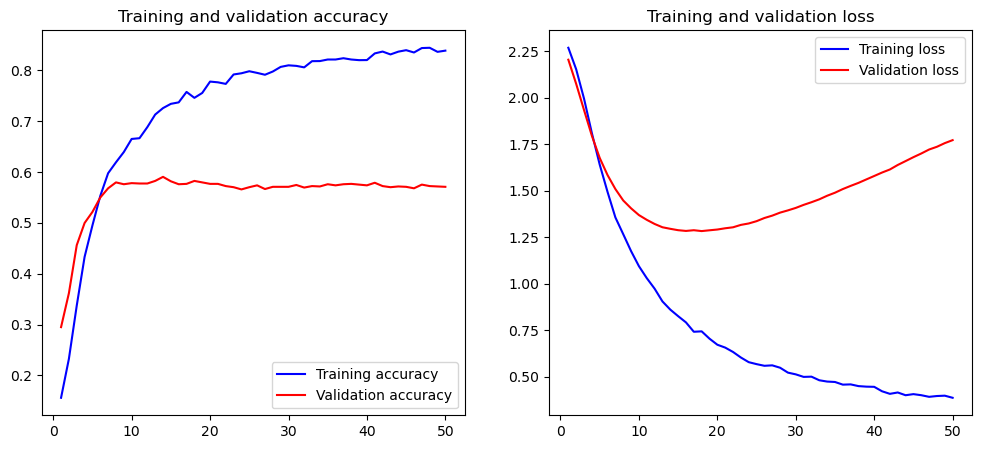

In [89]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    plt.plot(x, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
plot_history(history)

In [90]:
text_labels = encoder.classes_ 
for i in range(20):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_text.iloc[i][:50], "...")
    print('Actual NewsType:' + test_cat.iloc[i])
    print("Predicted NewsType: " + predicted_label + "\n") 

1/1 [==============================] - 0s 66ms/step
যুদ্ধ ব্যবসায়ী এরিক প্রিন্স কেন মিয়ানমারে ...
Actual NewsType:মতামত 
Predicted NewsType: আন্তর্জাতিক 

1/1 [==============================] - 0s 28ms/step
যুদ্ধ যুদ্ধ খেলায় ‘হিরো’ ইমরান! ...
Actual NewsType:আন্তর্জাতিক 
Predicted NewsType: আন্তর্জাতিক 

1/1 [==============================] - 0s 26ms/step
যুদ্ধবাজদের এখন পোয়াবারো ...
Actual NewsType:আন্তর্জাতিক 
Predicted NewsType: বিনোদন 

1/1 [==============================] - 0s 27ms/step
যুদ্ধবিমান ভূপাতিতের দাবি ভারতের ‘যুদ্ধ উন্মাদনা’: ...
Actual NewsType:আন্তর্জাতিক 
Predicted NewsType: আন্তর্জাতিক 

1/1 [==============================] - 0s 29ms/step
যুদ্ধবিমানের অপব্যবহার, পাকিস্তানের কাছে জবাব চায়  ...
Actual NewsType:আন্তর্জাতিক 
Predicted NewsType: আন্তর্জাতিক 

1/1 [==============================] - 0s 27ms/step
যুদ্ধাপরাধীদের বিচার থমকে যাবে না: মোজাম্মেল হক ...
Actual NewsType:বাংলাদেশ 
Predicted NewsType: বাংলাদেশ 

1/1 [==============================] - 0s 29ms/step
যু

# Telugu

# Language modelling and Text classification

We try to analayze some textual data from the corpus and then classify the telugu texts based on their topic

In [91]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
import seaborn as sns
import os

In [92]:
train_path = "/kaggle/input/telugu-nlp/telugu_news/train_telugu_news.csv"

telugu_news_df = pd.read_csv(train_path)
telugu_news_df

,SNo,date,heading,body,topic
0,414,11-05-2017 00:39:13,ఐడిబిఐపై ఆర్‌బిఐ నజర్‌,భారీ ఎత్తున మొండిబకాయిలు పెరిగిపోవడంతో ఐడిబిఐ ...,business
1,2668,12-06-2017 00:40:32,బ్యాంకింగ్‌ చీఫ్‌లతో నేడు జైట్లీ భేటీ,న్యూఢిల్లీ : ఆర్థిక మంత్రి అరుణ్‌ జైట్లీ సోమవా...,business
2,19923,19-01-2017 19:51:31,కీలక వికెట్ తీసిన జడేజా..,కటక్: ఇంగ్లండ్‌తో జరుగుతున్న సెకండ్ వన్డే మ్యా...,sports
3,15762,23-11-2017 17:29:04,మరో రెచ్చగొట్టే చర్యకు దిగిన పాకిస్థాన్,\nఇస్లామాబాద్ : పాకిస్థాన్ అంతర్జాతీయ ఉగ్రవాది...,nation
4,8624,03-04-2017 15:48:23,గోవాలో కొడుకుతో కలిసి అల్లు అర్జున్ స్విమ్మింగ్!,స్టార్‌ హీరోగా వరుస సినిమాలతో బిజీగా ఉన్నప్పటి...,entertainment
...,...,...,...,...,...
17307,10296,02-02-2017 12:18:11,"చిరు,ఎన్టీఆర్ వల్ల కాజల్‌కు దక్కిందేమిటి..?",ఇండస్ట్రీలో హీరోయిన్‌గా రాణించాలంటే కేవలం గ్లా...,entertainment
17308,13641,20-12-2017 04:16:32,"హిమాచల్‌ సీఎం రేసులో నడ్డా, జైరామ్‌","షిమ్లా, డిసెంబరు 19: హిమాచల్‌ ప్రదేశ్‌ అసెంబ్ల...",nation
17309,17288,20-05-2017 03:00:10,సతతహరిత విప్లవం అవసరం,2022 నాటికి రైతుల ఆదాయం రెట్టింపు చేయడానికి క...,nation
17310,20882,13-06-2017 04:30:36,ఇంగ్లండ్‌ జెర్సీలో వార్న్‌..!,పందెంలో ఓడిన షేనలండన్: ఆస్ట్రేలియా స్పిన్ లెజె...,sports


# Text Pre-Processing

In [93]:
telugu_news_df.isna().sum()

SNo        0
date       0
heading    1
body       0
topic      0
dtype: int64

In [94]:
telugu_news_df[telugu_news_df["heading"].isna() == True]

,SNo,date,heading,body,topic
8073,14673,20-02-2017 15:23:53,NaN,ఈ కిరాతకుడు 200 మందిని అత్యాచారం చేసి.. 500 మం...,nation


In [95]:
del telugu_news_df["heading"]
del telugu_news_df["SNo"]

In [96]:
telugu_news_df["topic"].unique()

array(['business', 'sports', 'nation', 'entertainment', 'editorial'],
      dtype=object)

In [97]:
topic_dic = {}

c = 0
for un in telugu_news_df["topic"].unique():
    if un not in topic_dic:
        topic_dic[un] = c
        c += 1
        
topic_dic

{'business': 0, 'sports': 1, 'nation': 2, 'entertainment': 3, 'editorial': 4}

In [98]:
inv_topic_dict = {v: k for k, v in topic_dic.items()}

In [99]:
def func_topic(s):
    return topic_dic[s]

telugu_news_df["topic"] = telugu_news_df["topic"].apply(func_topic)

<Figure size 1000x800 with 0 Axes>

Text(0.5, 1.0, 'Distribution of the telugu news toics')

([<matplotlib.patches.Wedge at 0x70e444058a50>,
 [Text(0.9823447123723595, 0.4949736013910906, 'business'),
  Text(0.31568185256705006, 1.0537290771160466, 'sports'),
  Text(-1.0466054216763092, 0.3385514603686643, 'nation'),
  Text(0.2751131418477603, -1.0650412006972567, 'entertainment'),
  Text(1.079750110557109, -0.2100944995755749, 'editorial')],
 [Text(0.5358243885667415, 0.26998560075877664, '14.86%'),
  Text(0.1721901014002091, 0.5747613147905708, '11.02%'),
  Text(-0.570875684550714, 0.18466443292836232, '38.29%'),
  Text(0.150061713735142, -0.5809315640166854, '29.72%'),
  Text(0.588954605758423, -0.1145969997684954, '6.12%')])

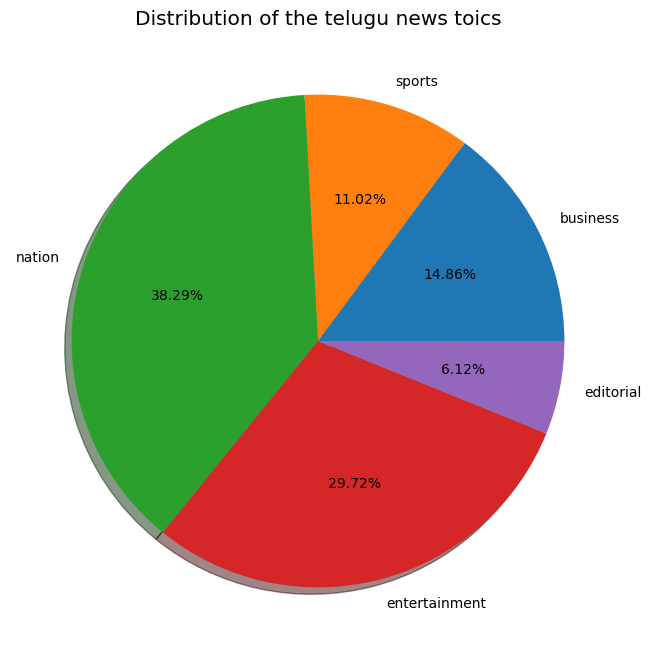

In [100]:
def get_count(df):
    
    unvals = list(df.unique())
    op = [0]*len(unvals)
    
    i = 0
    for un in unvals:
        op[i] = df[df == un].shape[0]
        i += 1
        
    return [list(unvals),op]

cont = get_count(telugu_news_df["topic"])
clables = cont[0]

labels = []
for c in clables:
    labels.append(inv_topic_dict[c])

plt.figure(figsize=(10,8))
plt.title("Distribution of the telugu news toics", fontsize = 14.5)
plt.style.use('seaborn-colorblind')
plt.pie(np.array(cont[1]), labels=labels, autopct='%1.2f%%', shadow=True)
plt.show()

In [101]:
date_df = telugu_news_df["date"]
del telugu_news_df["date"]

In [102]:
!pip install indic-nlp-library

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 34.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.5/100.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.2/121.2 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.7/84.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.0/94.0 kB 10.5 MB/s eta 0:00:00


In [103]:
!git clone https://github.com/anoopkunchukuttan/indic_nlp_resources.git

Cloning into 'indic_nlp_resources'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 139 (delta 2), reused 2 (delta 0), pack-reused 126
Receiving objects: 100% (139/139), 149.77 MiB | 38.30 MiB/s, done.
Resolving deltas: 100% (53/53), done.
Updating files: 100% (28/28), done.


In [104]:
!git clone https://github.com/anoopkunchukuttan/indic_nlp_library.git

Cloning into 'indic_nlp_library'...
remote: Enumerating objects: 1362, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 1362 (delta 111), reused 98 (delta 93), pack-reused 1219
Receiving objects: 100% (1362/1362), 9.56 MiB | 13.15 MiB/s, done.
Resolving deltas: 100% (721/721), done.


In [105]:
import sys
from indicnlp import common

# The path to the local git repo for Indic NLP library
INDIC_NLP_LIB_HOME=r"indic_nlp_library"

# The path to the local git repo for Indic NLP Resources
INDIC_NLP_RESOURCES=r"indic_nlp_resources"

# Add library to Python path
sys.path.append(r'{}\src'.format(INDIC_NLP_LIB_HOME))

# Set environment variable for resources folder
common.set_resources_path(INDIC_NLP_RESOURCES)

In [106]:
from indicnlp.tokenize import sentence_tokenize

indic_string = telugu_news_df["body"][0]
# Split the sentence, language code "hi" is passed for hingi
sentences=sentence_tokenize.sentence_split(indic_string, lang='te')

# print the sentences
for t in sentences:
    print(t)

భారీ ఎత్తున మొండిబకాయిలు పెరిగిపోవడంతో ఐడిబిఐ వ్యవహారాలపై భారత రిజర్వు బ్యాంకు (ఆర్‌బిఐ) ఒక కన్నేసింది.
ఐడిబిఐ బ్యాంకును ఆర్‌బిఐ వాచ్‌లి్‌స్టలో చేర్చినట్టుగా తెలిసింది.
నికర మొండిపద్దుల మొత్తం 6 శాతం దాటడం, వరసగా రెండేళ్ల పాటు నష్టాలను  ప్రకటించడం, కాపిటల్‌ అడెక్వసీ నిర్దేశిత ప్రమాణాల కంటే తగ్గడం. . . ఈ సందర్భాల్లో బ్యాంకులను ఆర్‌బిఐ వాచ్‌ లిస్ట్‌లో చేరుస్తుంది.
తమ బ్యాంకుకు సంబంధించి ఆర్‌బిఐ ప్రాంప్ట్‌ కరెక్టీవ్‌ యాక్షన్‌ (పిసిఎ) చేపట్టినట్టు ఐడిబిఐ వెల్లడించింది.
గతంలో ఓవర్సీస్‌ బ్యాంక్‌, యునైటెడ్‌ బ్యాంక్‌కు సంబంధించి  కూడా ఆర్‌బిఐ పిసిఎ చేపట్టింది.
పిసిఎ వల్ల బ్యాంకుపై ఆర్థికంగా భారం పడదనీ, దీనివల్ల అంతర్గత నియంత్రణలు మెరుగుపడటంతో పాటు, కార్యకలాపాలు మెరుగవుతాయని ఐడిబిఐ వివరించింది.
ఆర్‌బిఐ ఆదేశాలకు అనుగుణంగా ఇప్పుడు మూలధనాన్ని పొదుపుగా వినియోగించడంపై  ఐడిబిఐ దృష్టి సారించాల్సి ఉంటుంది.
ఇందులో భాగంగా పరపతిపై నియంత్రణలు విధించడం, నియామకాలను నిలిపేయడం, కొత్త పెట్టుబడి పథకాలను పక్కన బెట్టడంవంటి చర్యలు తీసుకోవాల్సి ఉంటుం ది.
బ్యాంకు సరైన రీతిలో స్పందించని పక్షంలో మరో బలమైన బ్యాంకులో  వి

In [107]:
telugu_news_df["body_processed"] = telugu_news_df["body"].str.replace('\u200c', '')
telugu_news_df["body_processed"] = telugu_news_df["body_processed"].str.replace('\n', '')
telugu_news_df["body_processed"] = telugu_news_df["body_processed"].str.replace('\t', '')
telugu_news_df["body_processed"] = telugu_news_df["body_processed"].str.replace('\xa0', '')

In [108]:
PUNCT = string.punctuation

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT))

In [109]:
telugu_news_df["body_processed"][6665]

' టెలికాం షేర్లలో అమ్మకాల ఒత్తిడి'

In [110]:
from indicnlp.tokenize import sentence_tokenize


tot_telugu_text1 = ""

for t in telugu_news_df["body_processed"]:
  tot_telugu_text1 += t

# tot_sentances_telugu = []

tot_sentences = sentence_tokenize.sentence_split(tot_telugu_text1, lang='te')
print(len(tot_sentences))

273291


In [111]:
telugu_news_df["body_processed"] = telugu_news_df["body_processed"].apply(lambda text: remove_punctuation(text))

In [112]:
# telugu_news_df["body_processed"][0]
del telugu_news_df["body"]

In [113]:
tot_telugu_text = ""

c = 1
for t in telugu_news_df["body_processed"]:
  tot_telugu_text += t
  c += 1

print(c)

17313


In [114]:
len(tot_telugu_text)

23917934

# Tokenizing and building a vocabulary for the text

In [115]:
from indicnlp.tokenize import indic_tokenize  

vocab_dic  = {}
tokenized_text = []
heap_arr = []

for t in indic_tokenize.trivial_tokenize(tot_telugu_text):
    tokenized_text.append(t)
    heap_arr.append(len(vocab_dic))

    if t not in vocab_dic:
      vocab_dic[t] = 1

    else:
      vocab_dic[t] += 1

In [116]:
len(vocab_dic), len(tokenized_text)

(328911, 2932015)

In [117]:
len(heap_arr)

2932015

In [118]:
from nltk.probability import FreqDist 

freq_dist = FreqDist(vocab_dic)

# Heaps Law

Heaps' law is an empirical law that describes the relationship between the size of a text corpus and the vocabulary used in that corpus. It states that the size of the vocabulary in a corpus grows as the corpus size increases. Specifically, Heaps' law states that the number of unique words (or types) in a corpus is proportional to the square root of the corpus size. Mathematically, it can be represented as:

V = k * N^β

where V is the vocabulary size, N is the number of tokens (or words) in the corpus, k and β are empirical parameters that depend on the language and the nature of the corpus. The parameter β typically falls in the range of 0.4 to 0.6. Heaps' law has been observed to hold for a wide range of natural languages and text types, including written text, spoken text, and computer code.

<Figure size 1500x600 with 0 Axes>

Text(0.5, 1.0, "Heap's law graph")

Text(0.5, 0, 'Vocabulary size')

Text(0, 0.5, 'No.of words in the corpus (text size)')

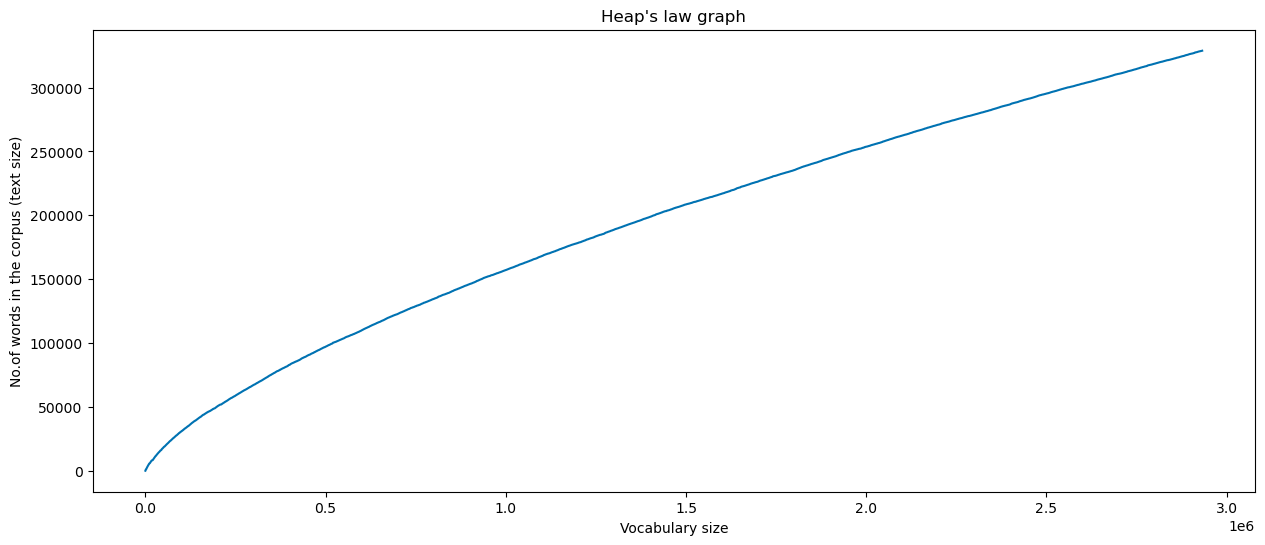

In [119]:
plt.figure(figsize = (15,6))
plt.plot(heap_arr)
plt.title("Heap's law graph")
plt.xlabel("Vocabulary size")
plt.ylabel("No.of words in the corpus (text size)")
plt.show()

In [120]:
vocab_dic_sorted = {k: v for k, v in sorted(vocab_dic.items(), key=lambda item: item[1], reverse = True)}

In [121]:
top_k_words = []

k = 50
c = 0

for key in vocab_dic_sorted.keys():

  if c == k:
    break

  top_k_words.append([key, vocab_dic_sorted[key]])
  c += 1

In [122]:
top_k_words_df = pd.DataFrame(top_k_words)
top_k_words_df.columns = ["word", "freq"]
top_k_words_df.head()

,word,freq
0,ఈ,38682
1,కూడా,16856
2,ఆ,15523
3,నుంచి,12650
4,ఆయన,9968


<Figure size 1500x600 with 0 Axes>

Text(0.5, 1.0, 'Top 50 words in the telugu corpus')

Text(0.5, 0, 'No.of words')

Text(0, 0.5, 'Frequency of the word')

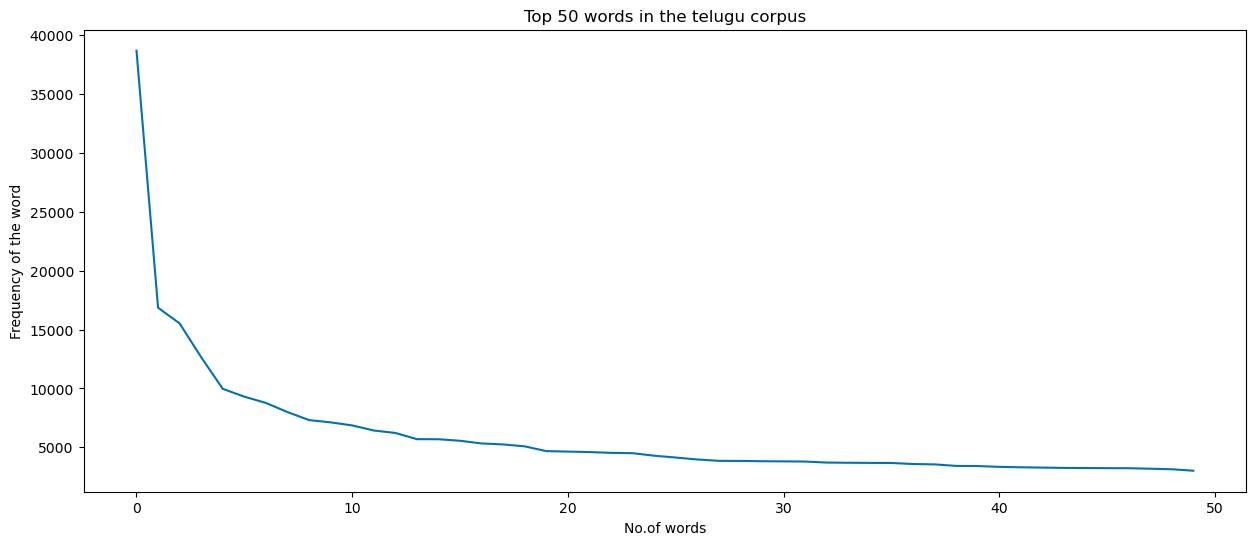

In [123]:
plt.figure(figsize = (15,6))
plt.plot(top_k_words_df["freq"])
plt.title("Top 50 words in the telugu corpus")
plt.xlabel("No.of words")
plt.ylabel("Frequency of the word")

plt.show()

In [124]:
telugu_words = list(vocab_dic_sorted.keys())

In [125]:
tot_sentences_proc = []

for sen in tot_sentences:
  tot_sentences_proc.append(remove_punctuation(sen))

In [126]:
tot_sentences_proc[0]

'భారీ ఎత్తున మొండిబకాయిలు పెరిగిపోవడంతో ఐడిబిఐ వ్యవహారాలపై భారత రిజర్వు బ్యాంకు ఆర్బిఐ ఒక కన్నేసింది'

# N-Gram Analysis

N-gram analysis is a text analysis technique that involves examining contiguous sequences of n words (or sometimes characters) in a text. N-grams are widely used in natural language processing (NLP) and text mining to identify patterns, classify text, and generate text.

For example, if we consider the sentence "The quick brown fox jumps over the lazy dog", we can generate different n-grams by taking contiguous sequences of n words:

- 1-gram (unigram): [The], [quick], [brown], [fox], [jumps], [over], [the], [lazy], [dog]

- 2-gram (bigram): [The quick], [quick brown], [brown fox], [fox jumps], [jumps over], [over the], [the lazy], [lazy dog]

- 3-gram (trigram): [The quick brown], [quick brown fox], [brown fox jumps], [fox jumps over], [jumps over the], [over the lazy], [the lazy dog]

By analyzing the frequency and distribution of n-grams in a text, we can gain insights into various aspects of the language, such as vocabulary, syntax, semantics, and style. N-gram analysis is also useful for tasks such as text classification, sentiment analysis, language modeling, and machine translation.

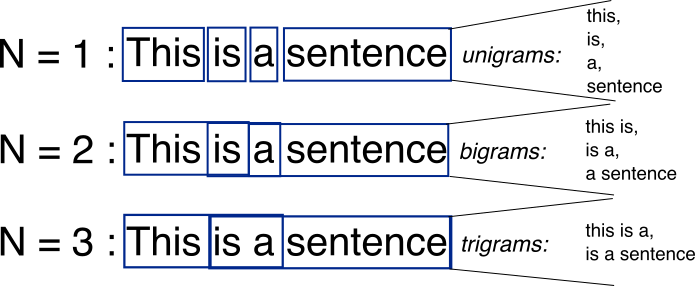

In [127]:
from nltk.util import ngrams

bigrams_telugu_vocab = {}

for sen in tot_sentences_proc:

  tokens = indic_tokenize.trivial_tokenize(sen)

  bigram = list(ngrams(tokens, 2)) 

  for big in bigram:
    if tuple(big) not in bigrams_telugu_vocab:
      bigrams_telugu_vocab[tuple(big)] = 1

    else:
      bigrams_telugu_vocab[tuple(big)] += 1

In [128]:
bigrams_telugu_vocab = {k: v for k, v in sorted(bigrams_telugu_vocab.items(), key=lambda item: item[1], reverse = True)}

In [129]:
print("Total no.of unique bi-grams :- ", len(bigrams_telugu_vocab))

Total no.of unique bi-grams :-  1609783


In [130]:
k = 30
print("Top" ,k ,"most-occuring bi-grams in the corpus are\n")
c = 0
for key in bigrams_telugu_vocab:
  if c == k:
    break
  print(key , " -> ", bigrams_telugu_vocab[key])
  c += 1

Top 30 most-occuring bi-grams in the corpus are

('ఈ', 'సినిమా')  ->  2016
('ఆ', 'తర్వాత')  ->  1275
('ఈ', 'ఏడాది')  ->  995
('కోట్ల', 'రూపాయల')  ->  976
('ఈ', 'సందర్భంగా')  ->  963
('సంగతి', 'తెలిసిందే')  ->  898
('అయితే', 'ఈ')  ->  824
('విషయం', 'తెలిసిందే')  ->  808
('ఈ', 'నేపథ్యంలో')  ->  800
('ఈ', 'సినిమాలో')  ->  794
('ఈ', 'నెల')  ->  788
('నోట్ల', 'రద్దు')  ->  767
('వ్యక్తం', 'చేశారు')  ->  720
('గత', 'ఏడాది')  ->  670
('నరేంద్ర', 'మోదీ')  ->  659
('ప్రధాని', 'మోదీ')  ->  640
('సోషల్', 'మీడియాలో')  ->  630
('ఈ', 'చిత్రం')  ->  629
('ఆయన', 'చెప్పారు')  ->  556
('పెద్ద', 'నోట్ల')  ->  542
('కేంద్ర', 'ప్రభుత్వం')  ->  534
('ఆ', 'సినిమా')  ->  531
('అవకాశం', 'ఉంది')  ->  518
('ఈ', 'మేరకు')  ->  502
('స్పష్టం', 'చేశారు')  ->  490
('ఇప్పటి', 'వరకు')  ->  466
('ఈ', 'విషయాన్ని')  ->  461
('ఆ', 'పార్టీ')  ->  451
('చాలా', 'మంది')  ->  450
('కోట్ల', 'రూపాయలు')  ->  441


In [131]:
trigrams_telugu_vocab = {}

for sen in tot_sentences_proc:
  tokens = indic_tokenize.trivial_tokenize(sen)
  trigram = list(ngrams(tokens, 3)) 

  for trig in trigram:
    if tuple(trig) not in trigrams_telugu_vocab:
      trigrams_telugu_vocab[tuple(trig)] = 1

    else:
      trigrams_telugu_vocab[tuple(trig)] += 1

trigrams_telugu_vocab = {k: v for k, v in sorted(trigrams_telugu_vocab.items(), key=lambda item: item[1], reverse = True)}

In [132]:
k = 30
print("Top" ,k ,"most-occuring tri-grams in the corpus are\n")
c = 0
for key in trigrams_telugu_vocab:
  if c == k:
    break
  print(key , " -> ", trigrams_telugu_vocab[key])
  c += 1

Top 30 most-occuring tri-grams in the corpus are

('పెద్ద', 'నోట్ల', 'రద్దు')  ->  427
('హైదరాబాద్', 'ఆంధ్రజ్యోతి', 'బిజినెస్')  ->  240
('ప్రధాని', 'నరేంద్ర', 'మోదీ')  ->  219
('కోట్ల', 'రూపాయల', 'నుంచి')  ->  165
('మంత్రి', 'అరుణ్', 'జైట్లీ')  ->  156
('ప్రధాన', 'మంత్రి', 'నరేంద్ర')  ->  152
('ఆర్థిక', 'మంత్రి', 'అరుణ్')  ->  136
('సమయానికి', 'క్లోజ్', 'చేసుకోవాలి')  ->  124
('మంత్రి', 'నరేంద్ర', 'మోదీ')  ->  118
('ఈ', 'సినిమా', 'షూటింగ్')  ->  115
('కాంగ్రెస్', 'ఉపాధ్యక్షుడు', 'రాహుల్')  ->  113
('అమెరికా', 'అధ్యక్షుడు', 'డొనాల్డ్')  ->  108
('అధ్యక్షుడు', 'డొనాల్డ్', 'ట్రంప్')  ->  107
('ఈ', 'సినిమా', 'కోసం')  ->  106
('ఉపాధ్యక్షుడు', 'రాహుల్', 'గాంధీ')  ->  106
('చేసిన', 'సంగతి', 'తెలిసిందే')  ->  105
('కేంద్ర', 'ఆర్థిక', 'మంత్రి')  ->  99
('ఈ', 'సందర్భంగా', 'ఆయన')  ->  98
('భారతీయ', 'జనతా', 'పార్టీ')  ->  96
('ఆగ్రహం', 'వ్యక్తం', 'చేశారు')  ->  94
('ప్రధాన', 'మద్దతు', 'స్థాయి')  ->  93
('నోట్ల', 'రద్దు', 'వల్ల')  ->  89
('ఆవేదన', 'వ్యక్తం', 'చేశారు')  ->  86
('కాంగ్రెస్', 'సీనియర

In [133]:
print("Total no.of unique tri-grams :- ", len(trigrams_telugu_vocab))

Total no.of unique tri-grams :-  1998929


In [134]:
four_grams_telugu_vocab = {}

for sen in tot_sentences_proc:
  tokens = indic_tokenize.trivial_tokenize(sen)
  fourgram = list(ngrams(tokens, 4)) 

  for fourg in fourgram:
    if tuple(fourg) not in four_grams_telugu_vocab:
      four_grams_telugu_vocab[tuple(fourg)] = 1

    else:
      four_grams_telugu_vocab[tuple(fourg)] += 1

four_grams_telugu_vocab = {k: v for k, v in sorted(four_grams_telugu_vocab.items(), key=lambda item: item[1], reverse = True)}

In [135]:
k = 30
print("Top" ,k ,"most-occuring 4-grams in the corpus are\n")
c = 0
for key in four_grams_telugu_vocab:
  if c == k:
    break
  print(key , " -> ", four_grams_telugu_vocab[key])
  c += 1

Top 30 most-occuring 4-grams in the corpus are

('ఆర్థిక', 'మంత్రి', 'అరుణ్', 'జైట్లీ')  ->  119
('ప్రధాన', 'మంత్రి', 'నరేంద్ర', 'మోదీ')  ->  117
('కాంగ్రెస్', 'ఉపాధ్యక్షుడు', 'రాహుల్', 'గాంధీ')  ->  89
('అమెరికా', 'అధ్యక్షుడు', 'డొనాల్డ్', 'ట్రంప్')  ->  87
('ట్రేడింగ్కు', 'ప్రారంభ', 'స్థాయి', 'కీలకం')  ->  77
('అంతకన్నా', 'దిగువన', 'మాత్రమే', 'షార్ట్')  ->  77
('దిగువన', 'మాత్రమే', 'షార్ట్', 'పొజిషన్లు')  ->  77
('మాత్రమే', 'షార్ట్', 'పొజిషన్లు', 'శ్రేయస్కరం')  ->  77
('ఇంట్రాడే', 'ట్రేడింగ్కు', 'ప్రారంభ', 'స్థాయి')  ->  75
('ట్రేడింగ్', 'వ్యూహం', 'నిఫ్టీ', 'ఫ్యూచర్స్')  ->  70
('కేంద్ర', 'ఆర్థిక', 'మంత్రి', 'అరుణ్')  ->  69
('వాస్తవిక', 'కదలికల', 'ఆధారంగా', 'నిర్ణయాలు')  ->  66
('కదలికల', 'ఆధారంగా', 'నిర్ణయాలు', 'తీసుకోవాలి')  ->  66
('మార్కెట్', 'వాస్తవిక', 'కదలికల', 'ఆధారంగా')  ->  65
('అంశాల', 'ఆధారంగా', 'ఇచ్చిన', 'సూచన')  ->  63
('ఇది', 'పూర్తిగా', 'ఆస్ర్టోటెక్నికల్', 'అంశాల')  ->  62
('పూర్తిగా', 'ఆస్ర్టోటెక్నికల్', 'అంశాల', 'ఆధారంగా')  ->  62
('ఆస్ర్టోటెక్నికల్', 'అంశాల', 'ఆధా

In [136]:
print("Total no.of unique 4-grams :- ", len(four_grams_telugu_vocab))

Total no.of unique 4-grams :-  1882201


In [137]:
five_grams_telugu_vocab = {}

for sen in tot_sentences_proc:
  tokens = indic_tokenize.trivial_tokenize(sen)
  fivegram = list(ngrams(tokens, 5)) 

  for fiveg in fivegram:
    if tuple(fiveg) not in five_grams_telugu_vocab:
      five_grams_telugu_vocab[tuple(fiveg)] = 1

    else:
      five_grams_telugu_vocab[tuple(fiveg)] += 1

five_grams_telugu_vocab = {k: v for k, v in sorted(five_grams_telugu_vocab.items(), key=lambda item: item[1], reverse = True)}

In [138]:
k = 30
print("Top" ,k ,"most-occuring 5-grams in the corpus are\n")
c = 0
for key in five_grams_telugu_vocab:
  if c == k:
    break
  print(key , " -> ", five_grams_telugu_vocab[key])
  c += 1

Top 30 most-occuring 5-grams in the corpus are

('అంతకన్నా', 'దిగువన', 'మాత్రమే', 'షార్ట్', 'పొజిషన్లు')  ->  77
('దిగువన', 'మాత్రమే', 'షార్ట్', 'పొజిషన్లు', 'శ్రేయస్కరం')  ->  77
('ఇంట్రాడే', 'ట్రేడింగ్కు', 'ప్రారంభ', 'స్థాయి', 'కీలకం')  ->  75
('వాస్తవిక', 'కదలికల', 'ఆధారంగా', 'నిర్ణయాలు', 'తీసుకోవాలి')  ->  66
('మార్కెట్', 'వాస్తవిక', 'కదలికల', 'ఆధారంగా', 'నిర్ణయాలు')  ->  65
('ఇది', 'పూర్తిగా', 'ఆస్ర్టోటెక్నికల్', 'అంశాల', 'ఆధారంగా')  ->  62
('పూర్తిగా', 'ఆస్ర్టోటెక్నికల్', 'అంశాల', 'ఆధారంగా', 'ఇచ్చిన')  ->  61
('ఆస్ర్టోటెక్నికల్', 'అంశాల', 'ఆధారంగా', 'ఇచ్చిన', 'సూచన')  ->  60
('కేంద్ర', 'ఆర్థిక', 'మంత్రి', 'అరుణ్', 'జైట్లీ')  ->  57
('సమయానికి', 'ప్రారంభ', 'స్థాయిసగటు', 'ఎటిపి', 'కన్నా')  ->  54
('ట్రేడింగ్', 'వ్యూహం', 'నిఫ్టీ', 'ఫ్యూచర్స్', '930')  ->  33
('ప్రారంభ', 'స్థాయిసగటు', 'ఎటిపి', 'కన్నా', 'పైన')  ->  33
('స్థాయిసగటు', 'ఎటిపి', 'కన్నా', 'పైన', 'ట్రేడవుతుంటే')  ->  33
('ఎటిపి', 'కన్నా', 'పైన', 'ట్రేడవుతుంటే', 'తగు')  ->  33
('ట్రేడవుతుంటే', 'తగు', 'స్టాప్లా్సతో', 'లాంగ్',

In [139]:
print("Total no.of unique 5-grams :- ", len(five_grams_telugu_vocab))

Total no.of unique 5-grams :-  1677911


In [140]:
ngrams_count = []

ngrams_count.append(len(vocab_dic_sorted))
ngrams_count.append(len(bigrams_telugu_vocab))
ngrams_count.append(len(trigrams_telugu_vocab))
ngrams_count.append(len(four_grams_telugu_vocab))
ngrams_count.append(len(five_grams_telugu_vocab))

In [141]:
ngrams_count

[328911, 1609783, 1998929, 1882201, 1677911]

<Figure size 1000x500 with 0 Axes>

<BarContainer object of 5 artists>

Text(0, 0.5, 'No.of unique n-grams')

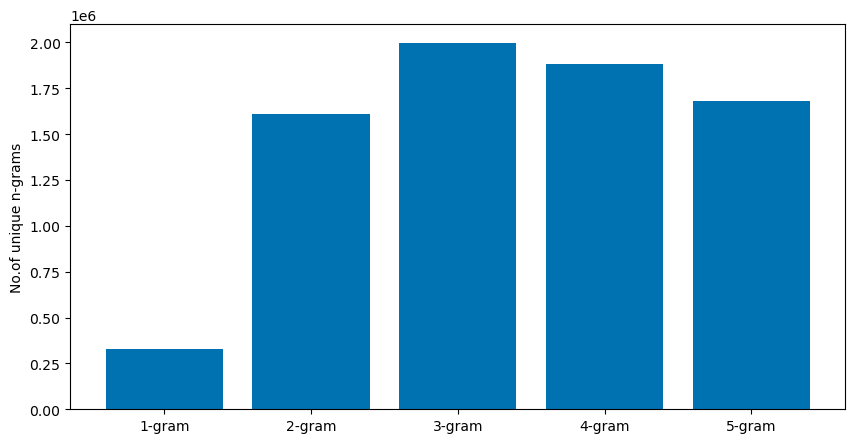

In [142]:
plt.figure(figsize = (10,5))
plt.bar(x = ["1-gram","2-gram","3-gram","4-gram","5-gram"], height = ngrams_count)
plt.ylabel("No.of unique n-grams")

Data sparsity is more of an issue in NLP than in other machine learning fields because we typically deal with large vocabularies where it is impossible to have enough data to actually observe examples of all the things that people can say. There will be many real phrases that we will just never see in the training data. 

# Building Model

## Using N-Grams and Laplace Smoothing

N-grams are a sequence of n words that occur together in a given text. N-gram analysis is the process of counting the frequency of n-grams in a text corpus. It is a useful tool in natural language processing, as it helps identify patterns and relationships between words in a text.

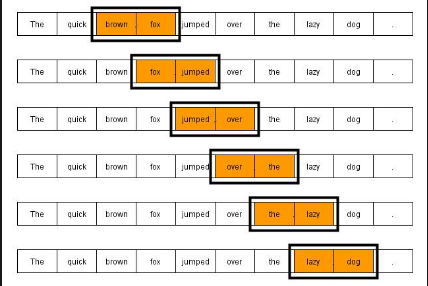

Laplace smoothing, also known as additive smoothing, is a technique used to estimate the probabilities of rare events in a dataset. It involves adding a small positive value to the observed frequency of each event to obtain a better estimate of its probability.

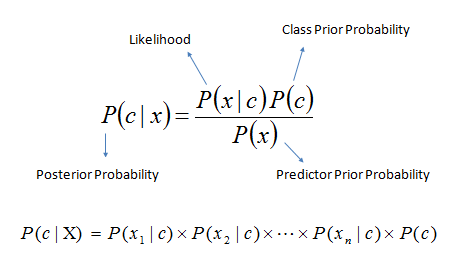

In the context of n-gram analysis, Laplace smoothing can be used to handle the problem of unseen n-grams. When an n-gram is not present in the training data, its frequency count will be zero, which will result in a zero probability estimate for that n-gram. Laplace smoothing can be used to avoid this problem by adding a small positive value to the observed frequency count of each n-gram, thereby ensuring that all n-grams have non-zero probability estimates.

In [143]:
telugu_news_df["topic"].unique()

array([0, 1, 2, 3, 4])

In [144]:
from indicnlp.tokenize import sentence_tokenize


# function to build a n-gram vocabulary
def build_n_gram_vocab(n, tot_sentences_proc):

  if n > 1:
    n_grams_telugu_vocab = {}

    for sen in tot_sentences_proc:
      tokens = indic_tokenize.trivial_tokenize(sen)
      ngram = list(ngrams(tokens, n))
      for ngm in ngram:
        if tuple(ngm) not in n_grams_telugu_vocab:
          n_grams_telugu_vocab[tuple(ngm)] = 1

        else:
          n_grams_telugu_vocab[tuple(ngm)] += 1

    n_grams_telugu_vocab = {k: v for k, v in sorted(n_grams_telugu_vocab.items(), key=lambda item: item[1], reverse = True)}


  else:
    n_grams_telugu_vocab = {}

    for sen in tot_sentences_proc:
      tokens = indic_tokenize.trivial_tokenize(sen)
      ngram = list(ngrams(tokens, 1)) 

      for ngm in ngram:
        if ngm not in n_grams_telugu_vocab:
          n_grams_telugu_vocab[ngm] = 1

        else:
          n_grams_telugu_vocab[ngm] += 1

    n_grams_telugu_vocab = {k: v for k, v in sorted(n_grams_telugu_vocab.items(), key=lambda item: item[1], reverse = True)}

  return n_grams_telugu_vocab

# function to get the vocabulary of the text of a class specified
def get_class_vocab(class_id, n_grams = 1):
  tot_text_class = ""

  for t in telugu_news_df[telugu_news_df["topic"] == class_id]["body_processed"]:
    tot_text_class += t

  tot_sentances_class = sentence_tokenize.sentence_split(tot_text_class, lang='te')

  vocab = build_n_gram_vocab(n_grams, tot_sentances_class)
    
  return vocab

In [145]:
# function to get the probabity of the input text to be belonging to a specific class
def get_prob_class_ngram(input_text, vocab, n_grams, class_id, laplace_param = 1):
  total_tokens = len(vocab)
  Prob_input = 1

  tokens = indic_tokenize.trivial_tokenize(input_text)

  vocab_n_1 = get_class_vocab(class_id, n_grams-1)
  
  if n_grams > 1:
    ngram = list(ngrams(tokens, n_grams))
    for ngm in ngram:

      prior_ngm = tuple(ngm[:n_grams-1])
      if prior_ngm in vocab_n_1:
        count_denom = vocab_n_1[prior_ngm]
      else:
        count_denom = 1

      if tuple(ngm) in vocab:
        count_w = vocab[tuple(ngm)]
      else:
        count_w = 0
      Prob_input *= ((count_w + laplace_param)/(count_denom+(laplace_param*len(vocab_n_1))))

  else:
    tokens = indic_tokenize.trivial_tokenize(sen)
    ngram = list(ngrams(tokens, 1))

    for ngm in ngram:
      if ngm in vocab:
        count_w = vocab[ngm]
      else:
        count_w = 0

      prob = count_w/total_tokens
      Prob_input *= count_w/total_tokens

  return Prob_input

def get_max_ind(arr):

  n = len(arr)

  max_ind = 0
  max_prob = arr[0]

  for i in range(1,n):

    if arr[i] > max_prob:
      max_ind = i
      max_prob = arr[i]

  return max_ind, max_prob


# Function to classify the given input text using the n_grams model
def classify_text(text, n_grams, laplace_param = 0):

  cls0_vocab = get_class_vocab(0, n_grams)
  cls1_vocab = get_class_vocab(1, n_grams)
  cls2_vocab = get_class_vocab(2, n_grams)
  cls3_vocab = get_class_vocab(3, n_grams)
  cls4_vocab = get_class_vocab(4, n_grams)

  probs_arr = []

  cls0_prob = get_prob_class_ngram(text, cls0_vocab, n_grams,0, laplace_param)
  cls1_prob = get_prob_class_ngram(text, cls1_vocab, n_grams,1, laplace_param)
  cls2_prob = get_prob_class_ngram(text, cls2_vocab, n_grams,2, laplace_param)
  cls3_prob = get_prob_class_ngram(text, cls3_vocab, n_grams,3, laplace_param)
  cls4_prob = get_prob_class_ngram(text, cls4_vocab, n_grams,4, laplace_param)

  probs_arr.append(cls0_prob)
  probs_arr.append(cls1_prob)
  probs_arr.append(cls2_prob)
  probs_arr.append(cls3_prob)
  probs_arr.append(cls4_prob)

#   We select the class with max probability as the final output
  print(probs_arr)
  class_pred, prob_cls = get_max_ind(probs_arr)

  return class_pred, prob_cls

In [146]:
text = "స్టార్ హీరోగా వరుస సినిమాలతో బిజీగా ఉన్నప్పటికీ కుటుంబంతో గడిపే అవకాశాన్ని ఏ మాత్రం వదులుకోవడం"
class_pred, prob = classify_text(text, 2, laplace_param = 2)
print("Predticted class ->",inv_topic_dict[class_pred], "\nPredicted with probabilty = " ,prob*100)

[7.539467241817366e-52, 7.31668157691397e-51, 1.1717407701942233e-55, 6.301709540971078e-50, 9.973784159019319e-55]
Predticted class -> entertainment 
Predicted with probabilty =  6.301709540971078e-48


In [147]:
# Using another text piece for the classification
text = "బాహుబలి2 సినిమా సంచలనం మెజారిటీ జనాలు మాత్రం బాహుబలి2ను ఆదరిస్తున్నారు సినీ ప్రముఖులు కూడా బాహుబలి2ను"
class_pred, prob = classify_text(text, 2, laplace_param = 2)
print("Predticted class ->",inv_topic_dict[class_pred], "\nPredicted with probabilty = " ,prob*100)

[2.0110665825536858e-53, 3.024676982957221e-52, 7.831626215013029e-56, 3.126894856378308e-51, 1.6914625670477634e-55]
Predticted class -> entertainment 
Predicted with probabilty =  3.1268948563783083e-49


In [148]:
text = "బాహుబలి2 సినిమా సంచలనం మెజారిటీ జనాలు మాత్రం బాహుబలి2ను ఆదరిస్తున్నారు సినీ ప్రముఖులు కూడా బాహుబలి2ను దర్శకుడు రాజమౌళిని ప్రశంసలతో ముంచెత్తుతున్నారు"
class_pred, prob = classify_text(text, 3, laplace_param = 3)
print("Predticted class ->",inv_topic_dict[class_pred], "\nPredicted with probabilty = " ,prob*100)

[8.100269552898122e-77, 9.034344690378677e-75, 2.8067273076842573e-81, 8.737449308546919e-79, 4.301426135460897e-79]
Predticted class -> sports 
Predicted with probabilty =  9.034344690378676e-73


In [149]:
text = "బాహుబలి2 సినిమా సంచలనం మెజారిటీ జనాలు మాత్రం బాహుబలి2ను ఆదరిస్తున్నారు సినీ ప్రముఖులు కూడా బాహుబలి2ను దర్శకుడు రాజమౌళిని ప్రశంసలతో ముంచెత్తుతున్నారు"
class_pred, prob = classify_text(text, 4, laplace_param = 5)
print("Predticted class ->",inv_topic_dict[class_pred], "\nPredicted with probabilty = " ,prob*100)

[5.454295653100135e-73, 8.120930489231527e-71, 4.8162484724192635e-77, 1.3511229185333792e-75, 2.7514511154241185e-74]
Predticted class -> sports 
Predicted with probabilty =  8.120930489231528e-69


In [150]:
text = "బాహుబలి2 సినిమా సంచలనం మెజారిటీ జనాలు మాత్రం బాహుబలి2ను ఆదరిస్తున్నారు సినీ ప్రముఖులు కూడా బాహుబలి2ను దర్శకుడు రాజమౌళిని ప్రశంసలతో ముంచెత్తుతున్నారు"
class_pred, prob = classify_text(text, 5, laplace_param = 5)
print("Predticted class ->",inv_topic_dict[class_pred], "\nPredicted with probabilty = " ,prob*100)

[9.383043939066722e-68, 1.1700941656830867e-65, 2.1836803718626474e-71, 4.175812490954377e-70, 1.0438681175394662e-68]
Predticted class -> sports 
Predicted with probabilty =  1.1700941656830867e-63
